# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/nouhalahyen/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

fatal: destination path 'exam_2025_session2' already exists and is not an empty directory.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


In [2]:
if torch.cuda.is_available():
    print("On est en GPU !")
    print("Nom du périphérique GPU :", torch.cuda.get_device_name(0))  # Affiche le nom du GPU
else:
    print("On est en CPU.")

On est en CPU.


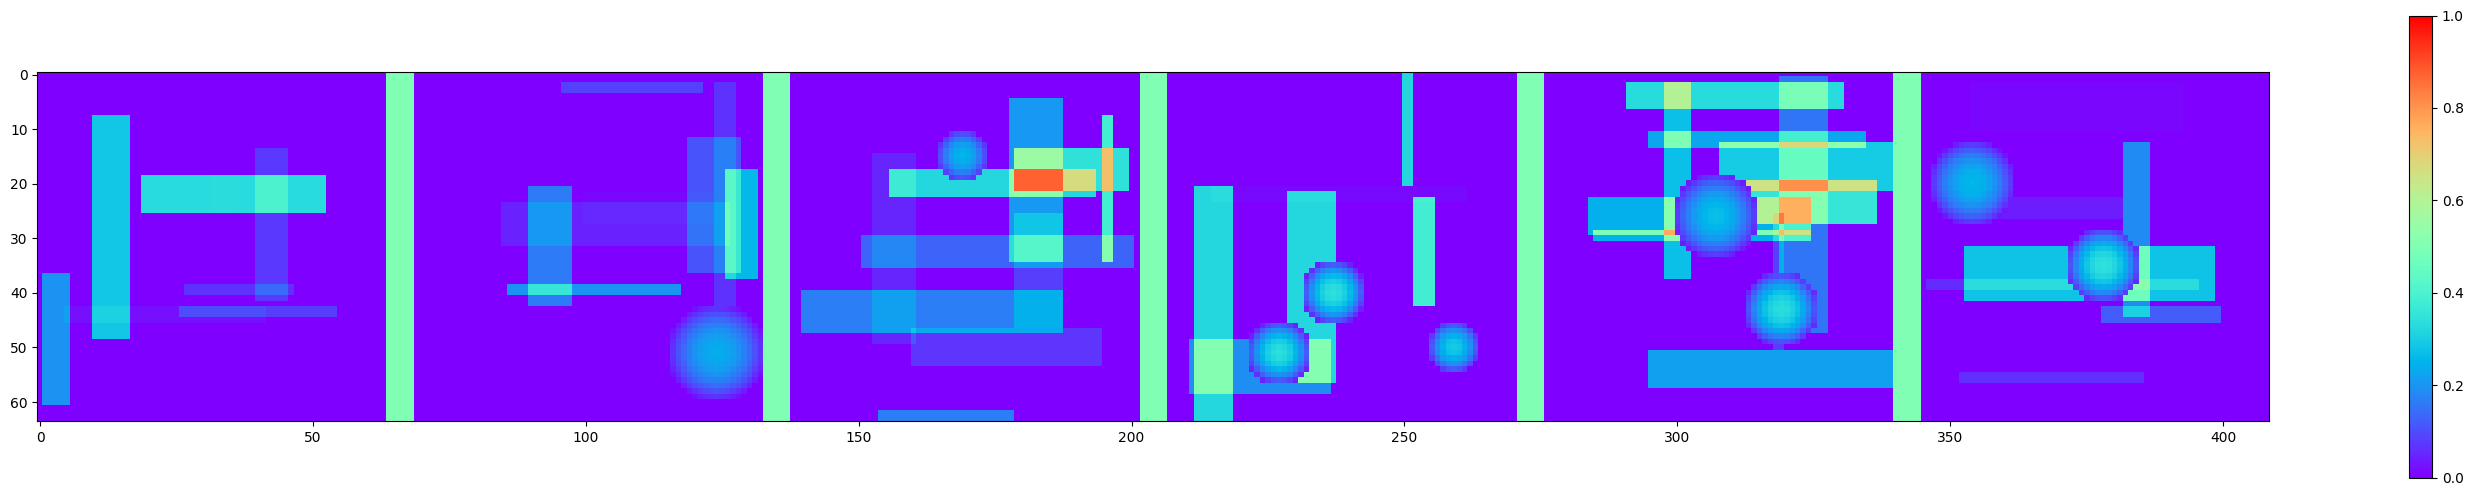

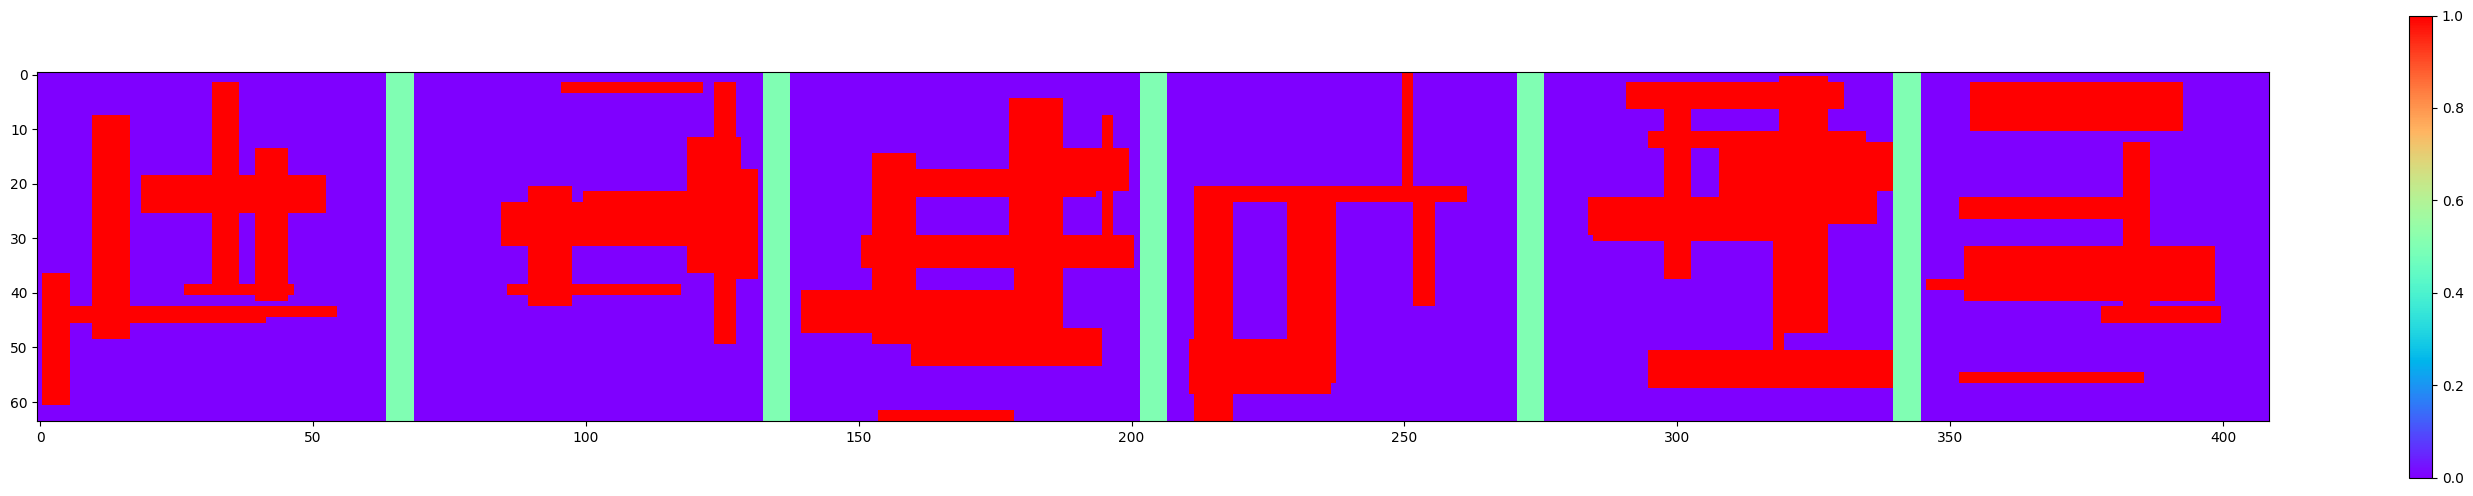

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

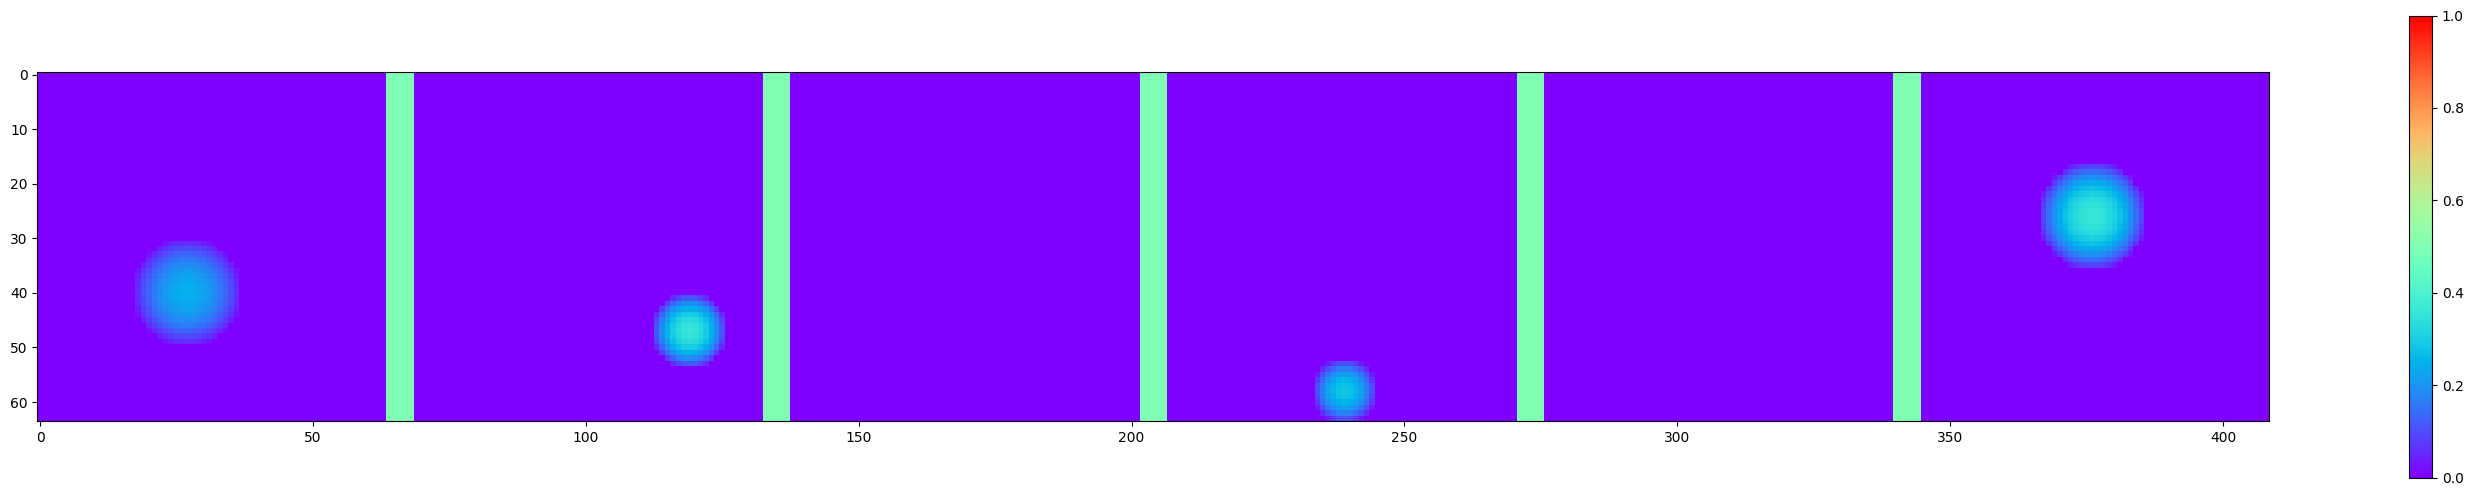

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

La supervision faible est un type d'apprentissage automatique où les données d'entraînement ne sont pas parfaitement étiquetées. Au lieu d'avoir des étiquettes explicites et précises pour chaque point de données, nous avons accès à des étiquettes bruitées, limitées ou imprécises.
Dans cet exercice, nous avons accès aux cibles idéales (la vérité terrain) pendant l'entraînement, mais ces cibles ne sont pas disponibles en pratique. Ce scénario s'apparente à la supervision faible car les cibles idéales peuvent être considérées comme une forme d'étiquettes faibles

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from utils import gen_dr, voir_batch2D, UNet

In [5]:
# Check GPU availability and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")  # Print device information

# Générer les données d'entraînement
input_train, target_train = gen_dr(1000) # Générer 1000 exemples d'entraînement

# Convertir les données en tenseurs PyTorch
input_train = torch.tensor(input_train, dtype=torch.float32)
target_train = torch.tensor(target_train, dtype=torch.float32)

# Créer le jeu de données
train_dataset = TensorDataset(input_train, target_train)

# Créer le DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Using device: cpu


<ipython-input-5-e7b5d1c9fe03>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_train = torch.tensor(input_train, dtype=torch.float32)
<ipython-input-5-e7b5d1c9fe03>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_train = torch.tensor(target_train, dtype=torch.float32)


In [6]:
# Créer le modèle UNet
in_channels=1
out_channels=1
model = UNet(1,1).to(device)

# Déplacer le modèle vers le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Initialiser l'optimiseur et la fonction de coût
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()  # Replace BCELoss with MSELoss

In [ ]:
# Boucle d'entraînement
for epoch in range(50):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Déplacer les données vers le GPU si disponible
        data, target = data.to(device), target.to(device)

        # Réinitialiser les gradients
        optimizer.zero_grad()

        # Faire une prédiction
        output = model(data)

        # Calculer la perte
        loss = criterion(output.float(), target.float())  # Explicitly cast to float if necessary
        # Rétropropagation
        loss.backward()

        # Mettre à jour les poids du modèle
        optimizer.step()

        # Afficher la progression
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/50], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

Epoch [1/50], Batch [1/32], Loss: 0.3400
Epoch [2/50], Batch [1/32], Loss: 0.0283
Epoch [3/50], Batch [1/32], Loss: 0.0142
Epoch [4/50], Batch [1/32], Loss: 0.0179


In [ ]:
# Générer des données de test
input_test, target_test = gen_dr(6)

# Convertir les données en tenseurs PyTorch
input_test = torch.tensor(input_test, dtype=torch.float32).to(device)

# Faire des prédictions sur les données de test
with torch.no_grad():
    output_test = model(input_test)

# Visualiser les sorties
fig = plt.figure(figsize=(12, 6))
voir_batch2D(output_test.cpu(), 6, fig, k=0, min_scale=0, max_scale=1)
plt.show()

\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




In [ ]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

In [ ]:
# Assuming 'inputs' and 'targets' are your data and labels
dataset = TensorDataset(torch.Tensor(inputs), torch.Tensor(targets))

# Create the DataLoader
loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [ ]:
from torchvision.models import resnet18


# 2. Initialisation du modèle ResNet18
model = resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # Modify first layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Couche de sortie pour la prédiction de la médiane
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device) # Envoyer le modèle au GPU si disponible

# 3. Configuration de l'entraînement
criterion = nn.L1Loss()  # L1Loss pour la prédiction de la médiane
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. Boucle d'entraînement
epochs = 50  # Ajuster si nécessaire
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device) # Envoyer les données au GPU si disponible
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(loader)}], Loss: {loss.item():.4f}")

print("Entraînement terminé!")

**reponse** Les données sont générées à l'aide de la fonction gen_ex2, ce qui implique qu'elles sont probablement illimitées et tirées d'une distribution connue. Cela élimine les problèmes de surajustement à un ensemble d'entraînement limité.
Aussi La question demande spécifiquement d'entraîner un modèle pour prédire la médiane conditionnelle. Si l'objectif est uniquement d'obtenir de bonnes performances sur cette métrique spécifique sans se soucier de la généralisation à des données non vues, la validation peut être jugée moins critique.

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

In [ ]:

from torchvision.models import resnet18

# Custom Quantile Loss Function
class QuantileLoss(torch.nn.Module):
    def __init__(self, n):
        super(QuantileLoss, self).__init__()
        self.n = n  # n= 100 -> centiles
        self.t = torch.arange(1/n, 1, 1/n).cuda()  # quantile orders

    def forward(self, output, target):
        bs, _, nx, ny = target.shape  # Assuming target shape: [batch_size, 1, height, width]
        d = target.view(bs, 1, nx, ny) - output
        loss_by_pix = torch.dot(self.t, d.clamp(min=0)) + torch.dot(self.t - 1, d.clamp(max=0))
        loss = torch.mean(loss_by_pix)
        return loss

# Function to calculate the dot product (since it's not defined in the code)
def dot(a, b):
    return torch.sum(a * b)


# 2. Model Initialization with channel modification & 3 outputs
model = resnet18(pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) # Modify first layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)  # 3 outputs for median, Q1, Q3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 3. Training Setup with custom quantile loss
criterion = QuantileLoss(n=100)  # Instantiate with n=100 for centiles
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 4. Training Loop (adjust to handle 3 outputs)
epochs = 2
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs = model(data)  # Get 3 outputs

        # Calculate loss for each quantile using custom QuantileLoss
        loss = criterion(outputs[:, 0].unsqueeze(1), target.unsqueeze(1)) + \
               criterion(outputs[:, 1].unsqueeze(1), target.unsqueeze(1)) + \
               criterion(outputs[:, 2].unsqueeze(1), target.unsqueeze(1))

        loss.backward()
        optimizer.step()

        # Print training details every 100 batches
        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx+1}/{len(loader)}], Loss: {loss.item():.4f}")

print("Training completed!")

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

L'adaptation de domaine vise à améliorer la performance d'un modèle sur un domaine cible en utilisant des connaissances d'un domaine source. Les domaines source et cible ont des distributions de données différentes, mais partagent la même tâche.

L'exercice présente un cas d'adaptation de domaine :

Domaine source : gen_dr_train fournit des données d'entraînement avec une certaine distribution de formes géométriques.
Domaine cible : gen_dr_test fournit des données de test avec une distribution différente, plus dense en formes.
Décalage de domaine : La différence de densité et de distribution entre les données d'entraînement et de test représente un décalage de domaine.

Le modèle (UNet) entraîné sur le domaine source doit être adapté pour performer sur le domaine cible. L'adaptation de domaine permet de combler ce décalage et d'améliorer la généralisation du modèle sur les données de test.


**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).

C'est un probléme de segmentation sur des images biomédicales.
Les méthodes d'augmentation utilisées sont des  déformations élastiques aléatoires des échantillons d'entraînement. Elles sont essentielles pour entraîner un réseau de segmentation avec très peu d'images annotées. Ces déformations sont générées à l'aide de vecteurs de déplacement aléatoires sur une grille grossière de 3x3, les déplacements étant tirés d'une distribution gaussienne avec un écart-type de 10 pixels. Les déplacements par pixel sont ensuite calculés par interpolation bicubique. Enfin, des couches de drop-out à la fin du chemin contractant contribuent à une augmentation de données implicite.


L'origine du déséquilibre entre les classes cibles dans le contexte de l'article sur U-Net provient principalement de la distribution inégale des pixels appartenant à différentes classes dans les images biomédicales. Par exemple, dans les tâches de segmentation cellulaire, il peut y avoir une majorité de pixels appartenant à l'intérieur des cellules, tandis que les frontières entre les cellules sont sous-représentées.
Traitement du déséquilibre des classes :

Pour compenser ce déséquilibre, l'approche utilisée dans U-Net inclut :
-Un pondération des pixels dans la fonction de perte : Les pixels appartenant aux frontières entre les objets (comme les membranes cellulaires) reçoivent un poids plus élevé pour forcer le réseau à mieux apprendre ces régions critiques.
-L'utilisation de transformations élastiques pour l'augmentation des données : Cela permet de mieux généraliser l'apprentissage malgré le manque d'échantillons annotés et de réduire l'impact du déséquilibre en générant des variations des structures sous-représentées.
-Un équilibrage des fréquences de classe : En ajustant les poids des classes dans la fonction de perte pour donner plus d'importance aux classes minoritaires.